# Creating Directory and Unzipping data


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle (4).json to kaggle (4).json
User uploaded file "kaggle (4).json" with length 66 bytes


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

100% 1.63G/1.63G [00:27<00:00, 50.9MB/s]
100% 1.63G/1.63G [00:27<00:00, 62.7MB/s]


In [0]:
%%capture
!unzip CORD-19-research-challenge.zip

In [5]:
!pip install sentence-transformers

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 573kB 24.5MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
     |████████████████████████████████| 3.7MB 46.6MB/s 
     |████████████████████████████████| 1.0MB 50.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=0c54b8bda1e74103803d29fc1ecc807f56348852a3b8eadcdd621789de051cf2
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=0f130a726dd40650d50633b6a822c89bb285a8bd9b8bb3695aa203003a720064
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sentence-transformers sacremoses


In [0]:
from sentence_transformers import SentenceTransformer

In [0]:
import pandas as pd
import umap
import numpy as np
import torch

In [0]:
from tqdm.notebook import tqdm
import os
import json

Load model

In [9]:
model=SentenceTransformer('roberta-base-nli-mean-tokens')

100%|██████████| 459M/459M [00:06<00:00, 66.1MB/s]


In [0]:
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.']

corpus_embeddings = model.encode(corpus)

In [0]:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
query_embeddings =model.encode('let us ride ')

In [12]:
np.array(query_embeddings).shape

(12, 768)

In [0]:
import scipy
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]
results = zip(range(len(distances)), distances)
results = sorted(results, key=lambda x: x[1])

In [14]:
distances

array([0.76700816, 0.90578247, 0.85553762, 0.76001217, 0.82610219,
       0.8710951 , 0.96156659, 0.86850556, 1.03758841])

In [15]:
results

[(3, 0.7600121676272205),
 (0, 0.7670081573329106),
 (4, 0.8261021946554647),
 (2, 0.8555376240985484),
 (7, 0.8685055578666431),
 (5, 0.8710950985920307),
 (1, 0.905782465376263),
 (6, 0.9615665889738212),
 (8, 1.0375884114927518)]

In [0]:
#r=np.dot(np.array(query_embedding).reshape(-1,1),np.array(query_embedding).reshape(1,-1))/(np.linalg.norm(np.array(query_embedding).reshape(-1,1))*np.linalg.norm(np.array(query_embedding).reshape(-1,1)))

In [17]:
 for idx, distance in results[0:6]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))


A man is riding a horse. (Score: 0.2400)
A man is eating food. (Score: 0.2330)
A woman is playing violin. (Score: 0.1739)
The girl is carrying a baby. (Score: 0.1445)
A monkey is playing drums. (Score: 0.1315)
Two men pushed carts through the woods. (Score: 0.1289)


In [0]:
#1-r

# Cleaning



In [19]:
working_list=[]
#paths = ["D:\\ANKIT\\CORD\\comm_use_subset\\pdf_json\\", "D:\\ANKIT\\CORD\\noncomm_use_subset\\pdf_json\\"]
paths = ["comm_use_subset/comm_use_subset/pdf_json/", "noncomm_use_subset/noncomm_use_subset/pdf_json/"]
for p in paths:
    for file in tqdm(os.listdir(p)):
        t=[]
        print('{} file of {} size read.'.format(file,os.stat(p+file).st_size))
        text_content = '' # combine title, abstract, and body text or articles
        working_dict = dict({"abstract": [], "body_text":[]})
        content = json.load(open(p+file,'r'))
        #print(type(content))
        working_dict['paper_id'] = content['paper_id']
        working_dict['path'] = p
        if 'metadata' in content and 'title' in content['metadata']:
            working_dict['title'] = content['metadata']['title']
            #print('found title')
        if 'metadata' in content and 'authors' in content['metadata']:
            for i in range(len(content['metadata']['authors'])):
                t.append(content['metadata']['authors'][i]['first'].capitalize()+' '+content['metadata']['authors'][i]['last'].capitalize()+',')
            working_dict['authors'] = t
            #print('found title')
            text_content = text_content  +' '+ content['metadata']['title']
        if 'abstract' in content:
            #print('found abstract')
            for abst in content['abstract'] :
                text_content = text_content+' '+abst['text']
                working_dict['abstract'].append(abst['text'])    
        if 'body_text' in content:
            #print('found body text')
            for bt in content['body_text'] :
                text_content = text_content+' '+bt['text']
                working_dict['body_text'].append(bt['text'])
        
        working_dict['text'] = text_content
        working_list.append(working_dict)

Streaming output truncated to the last 5000 lines.
c444840c3b5380002dea23e1e8598f545a3470a5.json file of 95080 size read.
b121a4b1dc6d8e513631edeb11421f20aad79106.json file of 75573 size read.
10dd2aeb61d54b45337a96f3c6243b72d6764732.json file of 100894 size read.
a87c83a672852a6d046357d68715f3c3c0cdf5b1.json file of 207596 size read.
0899d745009fa75954f75b381c040aebd927832a.json file of 95427 size read.
621fb61c827a3f1f0c6c69849319ed45f6dc1f5b.json file of 52092 size read.
63c2fc6a6f91490370687f314718221c70e0f9b4.json file of 80501 size read.
8b9bec3c317211d347532e8991d2494098d16dc2.json file of 84187 size read.
6c0431081c9d7d41d0efddd87fb0244b401ef67c.json file of 28838 size read.
1b2079db92924c2ee758d437394789b4822d0327.json file of 78376 size read.
c29e836db0541b34ffaf6a75c8b7079fd98220d8.json file of 77549 size read.
412aab9232d9b674c8ba7519a3c85ae72c2f0b9e.json file of 146989 size read.
eb1cc7c78d58eee6f6f81092426a9a5c9aab696c.json file of 38776 size read.
ef6638accc1ef599ad1aafd

a5b52c5ad7be21e6896955d2a98b6fb99c963412.json file of 91878 size read.
a40363fa5527e9b6dbf6930b247a4608027e7983.json file of 122193 size read.
ffed5d2a31a0c1a0db11905fe378e7735b6d70ca.json file of 17841 size read.
107ff91ec95dea35a80145aebbe5322c08c57e5e.json file of 47151 size read.
37ab0d36dd92298368b797e0770ebfa03a36eca8.json file of 128302 size read.
37012151cf80cbbbc5ed684c0473b06b1f48d50a.json file of 36792 size read.
709c30173f5cfdd55b8636f71cf76d3788a0553d.json file of 40885 size read.
74bc0b72bd1e1984f0428c90223d5f9cceda5f22.json file of 469218 size read.
e38546111f1b9aba0e5a2b1cc174582d653a8317.json file of 67202 size read.
c761570812ca07ce01397ebabc220556f51e786e.json file of 131904 size read.
80786183397e485664fd049d086f6e3e38ba210f.json file of 98153 size read.
26b944ce8d2f033704c7aeef38b0c128c0dd18be.json file of 122668 size read.
64f48f817331fc485485f543207eee3d76f1b022.json file of 108209 size read.
a93ae58385828b5de96f52d447e0305af7dbfe80.json file of 87503 size read.


In [0]:
os.listdir('D:\\ANKIT\\CORD\\comm_use_subset\\pdf_json\\09561ed721369a7a9e077f7bea9022499c12b13d.json')


NotADirectoryError: [WinError 267] The directory name is invalid: 'D:\\ANKIT\\CORD\\comm_use_subset\\pdf_json\\09561ed721369a7a9e077f7bea9022499c12b13d.json'

In [0]:
filename='D:\\ANKIT\\CORD\\comm_use_subset\\pdf_json\\09561ed721369a7a9e077f7bea9022499c12b13d.json'
with open(filename, 'r+') as f:
        txt = json.load(f)

In [0]:
t=[]
for i in range(len(txt['metadata']['authors'])):
    t.append(txt['metadata']['authors'][i]['first']+' '+txt['metadata']['authors'][i]['last']+',')

In [0]:
t

['Laura White,', 'Brett Archer,', 'Marcello Pagano,']

In [20]:
working_list[1]

{'abstract': ['Molecular recognition elements (MREs) can be short sequences of single-stranded DNA, RNA, small peptides, or antibody fragments. They can bind to user-defined targets with high affinity and specificity. There has been an increasing interest in the identification and application of nucleic acid molecular recognition elements, commonly known as aptamers, since they were first described in 1990 by the Gold and Szostak laboratories. A large number of target specific nucleic acids MREs and their applications are currently in the literature. This review first describes the general methodologies used in identifying single-stranded DNA (ssDNA) aptamers. It then summarizes advancements in the identification and biosensing application of ssDNA aptamers specific for bacteria, viruses, their associated molecules, and selected chemical toxins. Lastly, an overview of the basic principles of ssDNA aptamer-based biosensors is discussed.'],
 'authors': ['Ka Lok,', 'Hong ,', 'Letha Sooter

In [21]:
len(working_list)

12287

In [22]:
import sys
sys.getsizeof(working_list)/1024

96.3125

# Loading JSON to Dataframe 
For better understanding


In [0]:
from pandas import json_normalize
df=json_normalize(working_list)

In [24]:
df

,abstract,body_text,paper_id,path,title,authors,text
0,[Background: Buruli ulcer (BU) caused by Mycob...,[Buruli ulcer (BU) caused by Mycobacterium ulc...,454a87f362323152fc47fe4593afc755422f1e7b,comm_use_subset/comm_use_subset/pdf_json/,Detection of Mycobacterium ulcerans by the Loo...,"[Anthony Ablordey,, Diana Amissah,, Isaac Frim...",Detection of Mycobacterium ulcerans by the Lo...
1,[Molecular recognition elements (MREs) can be ...,[Target detection in diagnostics and sensors r...,6eb0faeda9396efaf96674c33b40395012a01e0a,comm_use_subset/comm_use_subset/pdf_json/,Single-Stranded DNA Aptamers against Pathogens...,"[Ka Lok,, Hong ,, Letha Sooter,]",Single-Stranded DNA Aptamers against Pathogen...
2,[Gold nanoparticles (GNPs) have been widely ut...,[Recent advances in nanotechnology have reveal...,8b585680add23a7959772b785c2cb2afd82db152,comm_use_subset/comm_use_subset/pdf_json/,Molecular Sciences Application of Gold Nanopar...,"[Jin-ho Lee,, † Id,, Hyeon-yeol Cho,, Hye Choi...",Molecular Sciences Application of Gold Nanopa...
3,[Background: Acute respiratory infections (ARI...,[Acute respiratory infections (ARIs) are one o...,45c54d1883027b09c51ea00cb13b1980569592a6,comm_use_subset/comm_use_subset/pdf_json/,Viral aetiology of acute respiratory infection...,"[Binglin Cui,, Dangui Zhang,, Hui Pan,, Fan Zh...",Viral aetiology of acute respiratory infectio...
4,[Muscle wasting is one of the main features of...,[Cancer-induced muscle wasting is one of the h...,7c6c25dd6ccfcf04a3c49ab5718f07991fa0b96d,comm_use_subset/comm_use_subset/pdf_json/,Modulating Metabolism to Improve Cancer-Induce...,"[Fabio Penna,, Riccardo Ballarò,, Marc Beltrá,...",Modulating Metabolism to Improve Cancer-Induc...
...,...,...,...,...,...,...,...
12282,[The aim of the study was to comprehensively e...,[Patients with acute exacerbations of chronic ...,0c3068b22cb2cb50114316f9fed2738a943d2435,noncomm_use_subset/noncomm_use_subset/pdf_json/,Use of noninvasive ventilation at the pulmonar...,"[Le Peng,, Peng-wei Ren,, Xue-ting Liu,, Chao ...",Use of noninvasive ventilation at the pulmona...
12283,[The SNP rs12252-C allele alters the function ...,[T here is strong evidence that the interferon...,d2685fbd92927824244e9d90a145f59f44317db0,noncomm_use_subset/noncomm_use_subset/pdf_json/,ARTICLE Interferon-induced transmembrane prote...,"[Yong-hong Zhang,, Yan Zhao,, Ning Li,, Yan-ch...",ARTICLE Interferon-induced transmembrane prot...
12284,[Protein motions on all timescales faster than...,[The dynamic nature of proteins is one of the ...,98e85066186167e53509cadef5d5389f2087da2e,noncomm_use_subset/noncomm_use_subset/pdf_json/,Mesodynamics in the SARS nucleocapsid measured...,"[Michael Clarkson ae,, Ming Ae,, Elan Eisenmes...",Mesodynamics in the SARS nucleocapsid measure...
12285,[We have investigated the localization of Kexl...,[S ~.CREa'EO biologically active proteins and ...,8ba51fdaf2a9dc9a0b4defc7c07d360e0f9a3984,noncomm_use_subset/noncomm_use_subset/pdf_json/,Yeast Kexlp Is a Golgi-associated Membrane Pro...,"[Antony Cooper,, Howard Bussey,, Kex2p ,, Sec7...",Yeast Kexlp Is a Golgi-associated Membrane Pr...


In [0]:
df=df.drop(columns=['path'],axis=0)

In [0]:
se=np.array(model.encode('Supplementary Information An eco-epidemiological study of Morbilli-related paramyxovirus infection in Madagascar bats reveals host-switching as the dominant macro-evolutionary mechanism'))

In [0]:
for i in range(len(df['title'])):
    print(df['title'].iloc[i])

Streaming output truncated to the last 5000 lines.
Gene Expression Profiling in Cells with Enhanced c-Secretase Activity
Measuring healthcare preparedness: an all-hazards approach
Plasma proteomic profile of sulfur mustard exposed lung diseases patients using 2- dimensional gel electrophoresis
Plasmodium falciparum pre-erythrocytic stage vaccine development
Selective inhibition of Ebola entry with selective estrogen receptor modulators by disrupting the endolysosomal calcium OPEN
The effect of herd formation among healthcare investors on health sector growth in China
The osteogenic cell surface marker BRIL/IFITM5 is dispensable for bone development and homeostasis in mice
Direct association between pharyngeal viral secretion and host cytokine response in severe pandemic influenza
Ocular pathogenesis and immune reaction after intravitreal dispase injection in mice
pathogens Virus-Host Interactions Involved in Lassa Virus Entry and Genome Replication
Current Research on Non-Coding Ribonu

In [0]:
#for i in tqdm(range(500)):
#       enc=pd.Series(model.encode(df['title'].iloc[i]))
              

# BM25

In [26]:
!pip install rank-bm25

  Created wheel for rank-bm25: filename=rank_bm25-0.2-cp36-none-any.whl size=4162 sha256=ff04860f6bce53c9a954f09d19eff11729b4ed147b871ad7e232dc3f4dd43bf8
  Stored in directory: /root/.cache/pip/wheels/6f/0c/1f/78945dd6a5478bbcdb50d73ac96ae5af2ffcdfcd374fd9b1bf
Successfully built rank-bm25


In [0]:
from rank_bm25 import BM25Okapi

# Checking how many instances of empty TITLE

In [0]:
count=0
for i in range(len(df)):
    if len(df['title'].iloc[i])==0:
        df['title'].iloc[i]=df['title'].iloc[i]+' '

After filling

In [29]:
count

0

In [0]:
title_corpus=df['title'].tolist()                 

In [0]:
#titleDF=pd.DataFrame(title_corpus)

BM25 for titles

In [0]:
title_Tokenized = [doc.split(" ") for doc in title_corpus]
title_Index = BM25Okapi(title_Tokenized )
doc_scores = title_Index.get_scores("Proportion of pediatric patients who were asymptomatic".split(' '))

resultsTitle=title_Index.get_top_n("Proportion of pediatric patients who were asymptomatic".split(' '), title_corpus, n=1024)

In [0]:
resTitle=pd.DataFrame(resultsTitle,columns=["Titles"])

pop empty items from the list

In [0]:
for i in range(len(resultsTitle)):
  if resultsTitle[i]=='':
    resultsTitle.pop(i)

In [0]:
resultsTitle=pd.DataFrame(resultsTitle,columns=['Titles']).drop_duplicates()
finalTitle=resultsTitle['Titles'].tolist()

# Cleaned Result : Title

In [176]:
finalTitle

['Patient and health system delays before registration among migrant patients with tuberculosis who were transferred out in China',
 'Impact of isolation on hospitalised patients who are infectious: systematic review with meta-analysis',
 'Viral etiology of acute respiratory infections in pediatric patients in Lebanon',
 'Risk factors of 90-day rehospitalization following discharge of pediatric patients hospitalized with mycoplasma Pneumoniae pneumonia',
 'First introduction of pandemic influenza A/H1N1 and detection of respiratory viruses in pediatric patients in Central African Republic',
 'Coronavirus infections in hospitalized pediatric patients with acute respiratory tract disease',
 'Molecular epidemiology of influenza B virus among hospitalized pediatric patients in Northern Italy during the 2015-16 season',
 'Molecular characteristics and successful management of a respiratory syncytial virus outbreak among pediatric patients with hemato-oncological disease',
 'Evidence based r

# Some articles don't have ABSTRACTS

In [0]:
for i in range(len(df['abstract'])):
  if len(df['abstract'].iloc[i])==0:
    df['abstract'].iloc[i].append('EMPTY')

Now we extract list--> list(str...n)

In [0]:
abstract_corpus=[]
for i in range(len(df['abstract'])):
    abstract_corpus.append(df['abstract'].iloc[i][0])

In [0]:
#abstractDF=pd.DataFrame(abstract_corpus)

In [0]:
abstract_Tokenized = [doc.split(" ") for doc in abstract_corpus]


Indexing corpus and the calculating the BM25 scores

In [0]:
bm25 = BM25Okapi(abstract_Tokenized )

In [0]:
doc_scores = bm25.get_scores("how do I treat coronavirus?".split(' '))

In [188]:
doc_scores

array([0.        , 0.        , 0.        , ..., 0.        , 4.30743325,
       0.        ])

Results for abstracts

In [0]:

results=bm25.get_top_n("how do I treat coronavirus?".split(' '), abstract_corpus, n=1024)

In [56]:
type(results)

list

For removing empty results

In [0]:
for i in range(len(results)):
  if results[i]=='':
    results.pop(i)

In [0]:
results=pd.DataFrame(results,columns=['Abstract'])

In [0]:
res=results.drop_duplicates()

In [0]:
abstract_final=res['Abstract'].tolist()

# Cleaned result abstract

In [194]:
len(abstract_final)

1009

# Clustering

In [0]:
clusterTitle=finalTitle

In [0]:
import time

In [179]:
%time title_encodings=model.encode(clusterTitle)


CPU times: user 1min 13s, sys: 5.47 s, total: 1min 18s
Wall time: 1min 18s


In [0]:
from sklearn.cluster import KMeans

In [0]:
Titlecorpus_embeddings=title_encodings

In [0]:
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters,init='k-means++')
clustering_model.fit(Titlecorpus_embeddings)
cluster_assignment = clustering_model.labels_



In [99]:
cluster_assignment

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,

In [100]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(clusterTitle[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['Development of therapeutic antibodies for the treatment of diseases', 'Using echocardiography to guide the treatment of novel coronavirus pneumonia', 'Antibody therapies for the prevention and treatment of viral infections', 'Interleukin-18 expression and the response to treatment in patients with psoriasis', 'Cyclophilin A as a target in the treatment of cytomegalovirus infections', 'Idiopathic acute myocarditis during treatment for controlled human malaria infection: a case report', 'Profile of resistance to IVIG treatment in patients with Kawasaki disease and concomitant infection', 'Randomised controlled trial of rhinothermy for treatment of the common cold: a feasibility study', 'Diagnosis and treatment of viral diseases in recipients of allogeneic hematopoietic stem cell transplantation', 'Prophylactic and therapeutic remdesivir (GS-5734) treatment in the rhesus macaque model of MERS-CoV infection', 'Non-lytic antibiotic treatment in community-acquired pneumococcal p

#Ranking

##  The idea is to use both Titles and Abstracts as a means of ranking.
####- Titles often contribute to CTR , this higher clickthrough rate might correspond to a semantically similar query.

####- Also abstracts are an summary of the papers itself therefore being very valuable.


## Title Ranking

In [0]:
query=["Proportion of pediatric patients who were asymptomatic"]

In [0]:
query_embedding=model.encode(query)

In [0]:
quer

In [0]:
import scipy
for query, query_embedding in zip(query, query_embedding):
    distances = scipy.spatial.distance.cdist([query_embedding], Titlecorpus_embeddings, "cosine")[0]
results = zip(range(len(distances)), distances)
res= sorted(results, key=lambda x: x[1])

In [183]:
res

[(250, 0.272278483190025),
 (584, 0.30659693510426866),
 (339, 0.323629091642479),
 (902, 0.33607271101511005),
 (930, 0.33924460775675835),
 (20, 0.3416121489381687),
 (817, 0.34347157517297533),
 (494, 0.34357514367716646),
 (613, 0.34625882848875356),
 (436, 0.34807474391075344),
 (716, 0.34848776370675405),
 (634, 0.35475209597373947),
 (491, 0.35778781360920353),
 (707, 0.35865998315458736),
 (958, 0.3618331746815153),
 (792, 0.36509814147802),
 (305, 0.3666702392357246),
 (421, 0.36750436685115273),
 (855, 0.37264873314060554),
 (754, 0.37306349743769607),
 (486, 0.3739293349329448),
 (988, 0.3756928883883639),
 (692, 0.37652846054463507),
 (172, 0.3825135275698214),
 (560, 0.38259510357789395),
 (925, 0.3826172251737334),
 (706, 0.38442852117619375),
 (758, 0.385129954442723),
 (954, 0.38778715698677924),
 (454, 0.3892365841992692),
 (58, 0.3941102261489602),
 (580, 0.3960163764519684),
 (413, 0.39758085575915214),
 (462, 0.39824533693258934),
 (15, 0.3989303871742629),
 (337, 0

In [184]:
 for idx, distance in res:
        print(clusterTitle[idx], "(Score: %.4f)" % (1-distance))

Recognition of aerosol transmission of infectious agents: a commentary (Score: 0.7277)
Distribution of the Phenotypic Effects of Random Homologous Recombination between Two Virus Species (Score: 0.6934)
Review Article Advances in Diagnosis of Respiratory Diseases of Small Ruminants (Score: 0.6764)
A Loss of Function Analysis of Host Factors Influencing Vaccinia virus Replication by RNA Interference (Score: 0.6639)
BMC Genomics Evidence of host-virus co-evolution in tetranucleotide usage patterns of bacteriophages and eukaryotic viruses (Score: 0.6608)
Characterization of Neutralizing Profiles in HIV-1 Infected Patients from whom the HJ16, HGN194 and HK20 mAbs were Obtained (Score: 0.6584)
Role of viruses in asthma (Score: 0.6565)
materials Tuning Optical and Granulometric Properties of Gold Nanostructures Synthesized with the Aid of Different Types of Honeys for Microwave-Induced Hyperthermia (Score: 0.6564)
Antioxidant effect of angiotensin (1-7) in the protection of pancreatic β cell

## Abstract Ranking

In [0]:
abstract_500=abstract_corpus[:500]

In [204]:
%time abstract_encodings=model.encode(abstract_500)

CPU times: user 1min 50s, sys: 5.52 s, total: 1min 56s
Wall time: 1min 56s


In [0]:
query=["how do I treat coronavirus?"]

In [0]:
query_embedding=model.encode(query)

In [0]:
import scipy
for query, query_embedding in zip(query, query_embedding):
    distances = scipy.spatial.distance.cdist([query_embedding], abstract_encodings, "cosine")[0]
results = zip(range(len(distances)), distances)
res= sorted(results, key=lambda x: x[1])

In [220]:
 for idx, distance in res:
        print(abstract_500[idx], "(Score: %.4f)" % (1-distance))

Background: Rift Valley Fever (RVF) is a mosquito-borne viral zoonosis. To detect RVF virus (RVFV) infection, indirect immunoglobulin G (IgG) and immunoglobulin M (IgM) enzyme linked immunosorbent assays (ELISAs) which utilize recombinant RVFV nucleocapsid (RVFV-N) protein as assay antigen, have reportedly been used, however, there is still a need to develop more sensitive and specific methods of detection. Methods: RVFV-N protein was expressed in Escherichia coli (E. coli) and purified by histidine-tag based affinity chromatography. This recombinant RVFV-N (rRVFV-N) protein was then used as antigen to develop an IgG sandwich ELISA and IgM capture ELISAs for human sera. Ninety six serum samples collected from healthy volunteers during the RVF surveillance programme in Kenya in 2013, and 93 serum samples collected from RVF-suspected patients during the 2006-2007 RVF outbreak in Kenya were used respectively, to evaluate the newly established rRVFV-N protein-based IgG sandwich ELISA and I

In [0]:
vizabstracts=[]
for idx, distance in res:
        vizabstracts.append(abstract_500[idx])

# VIZ

In [212]:
len(abstract_encodings)

500

In [0]:
#for i in range(len(vizabstracts)):
#      if vizabstracts[i]=='EMPTY':
#           vizabstracts.pop(i)

In [291]:
len(vizabstracts)

439

In [237]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [0]:
stopwords = set(STOPWORDS)

In [0]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(str(vizabstracts))

# Word Cloud 


<Figure size 432x288 with 0 Axes>

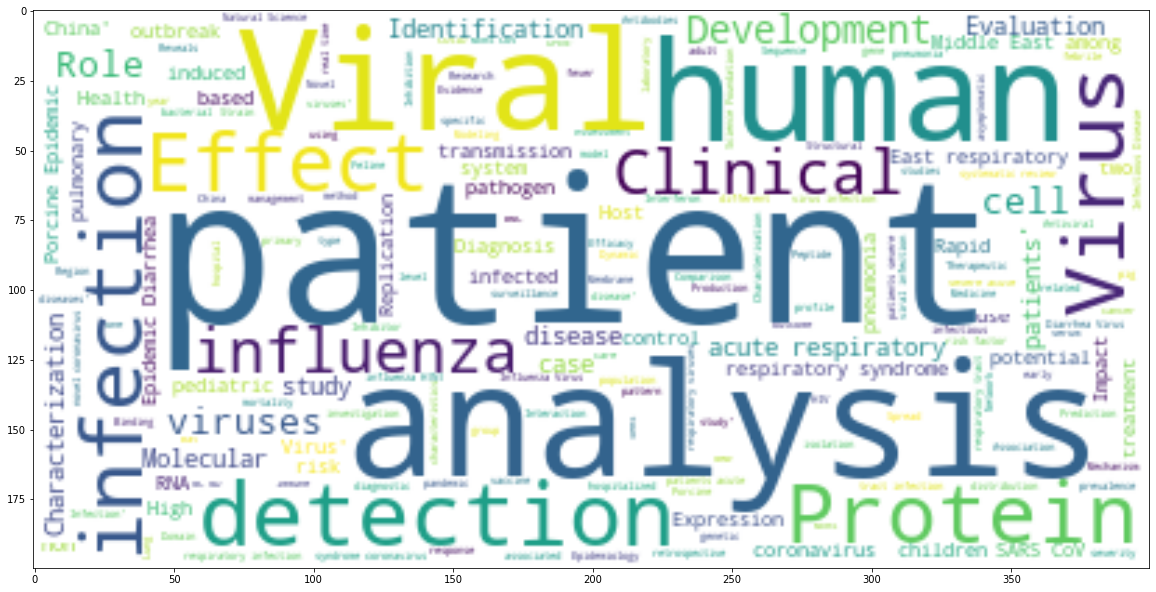

In [261]:
plt.suptitle("Word Cloud for Abstracts retrieved")
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("on")
plt.show()

# Word Cloud Titles

We are trying to understand the prevalent themes in various abstracts
Also we remove words which are too freq occuring in Titles 
So as to understand the different themes

In [0]:
stopwords.update(["human", "patient", "Viral", "Virus", "analysis","detection"])
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white").generate(str(clusterTitle))

<Figure size 432x288 with 0 Axes>

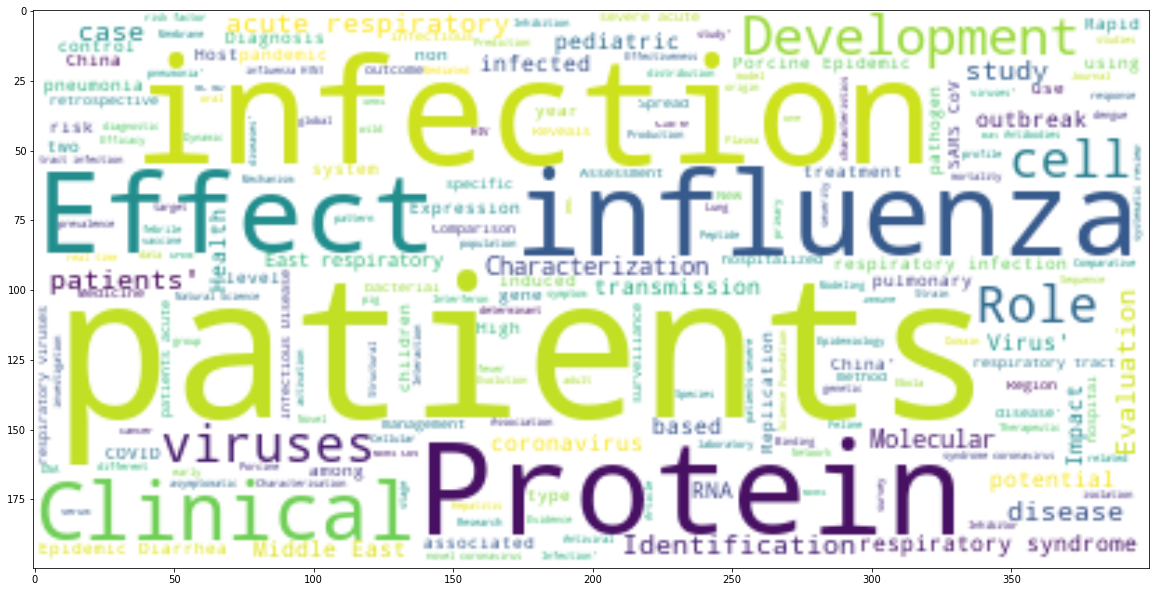

In [266]:
plt.suptitle("Word Cloud for Abstracts retrieved")
plt.figure(figsize=[20,20])
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("on")
plt.show()

# Semantic Space

Let us now see  how the vectors appear in semantic space

In [0]:
import re

In [0]:
for i in range(len(abstract_500)):
  abstract_500[i]=re.sub('[^A-Za-z0-9]+', ' ', abstract_500[i])

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(abstract_encodings)


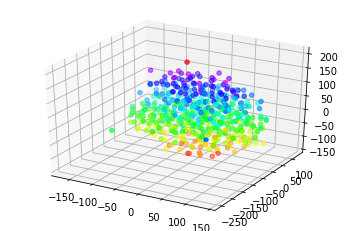

<Figure size 1440x1440 with 0 Axes>

In [329]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
x=X_embedded[:,0]
y=X_embedded[:,1]
z=X_embedded[:,2]
plt.figure(figsize=(20,20))
ax.scatter(x,y,z,c=z,cmap='hsv')

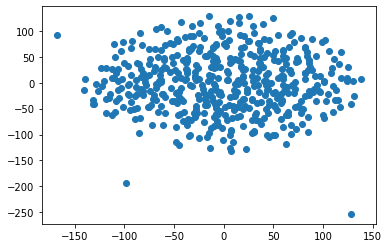

In [330]:
plt.scatter(x,y)

Titles

In [0]:
from sklearn.manifold import TSNE
query_embedded = TSNE(n_components=3).fit_transform(query_embedding.reshape(-1,1))
xq=query_embedded[0]
yq=query_embedded[1]
zq=query_embedded[2]

# Embedding Query in same semantic space  as other Titles

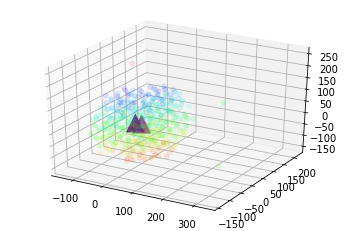

<Figure size 1440x1440 with 0 Axes>

In [371]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(title_encodings)
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
x=X_embedded[:,0]
y=X_embedded[:,1]
z=X_embedded[:,2]
plt.figure(figsize=(20,20))

ax.scatter(x,y,z,c=z,cmap='hsv',alpha=0.1)
ax.scatter(xq,yq,zq,c='purple',s=300,marker='^')

# Sections

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section